<a href="https://colab.research.google.com/github/ScriptsRemote/SCRIPTSREMOTE/blob/main/00_POST_COLAB_SPYNDEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***POST 1 - Spyndex no GEE***

In [ ]:
##Instalação do pacote
!pip install -U spyndex
!pip install earthengine-api
!pip install eemont geemap
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
##importando as bibliotecas
import spyndex
import ee, eemont, geemap
import geemap.colormaps as cm
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Autenticação
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=_FtnarK8m-yA-PAe8Okdw36pkwPaPXJWZ4c9gtzujOI&tc=kO_ZpegK_uwQCumn_5_2VB3nR_r2HpnJrs0GdsgYCgM&cc=gxh8-xbXKUfPXf83157f4I-GqNWgW4zgHbZNbzqQwK0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJo6EsrOPUC4TEXzA1utpWCCZE_Aei04LHeIV9DSf-5MvFnZ6NjvJqY

Successfully saved authorization token.


In [ ]:
##Região de interesse e imagens
roi =ee.Geometry.Point([-47.89683986294218, -15.805384001594478])

sentinel =ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")\
                          .filterBounds(roi)\
                          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',1))\
                          .sort('CLOUDY_PIXEL_PERCENTAGE')\
                          .first()\
                          .multiply(0.0001) ###fator de escala



In [ ]:
#Fórmula
print(spyndex.indices['NDVI'].formula)
print(spyndex.indices['NDVI'].reference)

(N-R)/(N+R)
https://ntrs.nasa.gov/citations/19740022614


In [ ]:
##Vamos calcular alguns índices!
idx = spyndex.computeIndex(
    index = ["VARI","NDWI","NDVI"],
    params = {
        "R": sentinel["B4"],
        "G": sentinel["B3"],
        "B": sentinel["B2"],
        "N": sentinel["B8"]
    }
)

##Vendo as bandas os índices cálculados
img = sentinel.addBands(idx)
print(img.bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'VARI', 'NDWI', 'NDVI']


In [ ]:
##Plotando o resultado
Map = geemap.Map()
Map.addLayer(img[["B4","B3","B2"]],{"min":0,"max":0.3},"RGB")
Map.addLayer(img["VARI"],{"palette":cm.palettes.ndvi},"VARI")
Map.addLayer(img["NDWI"],{"palette":cm.palettes.ndvi},"NDWI")
Map.addLayer(img["NDVI"],{"palette":cm.palettes.ndvi},"NDVI")
Map.centerObject(img,13)
Map

Map(center=[-15.847571460161536, -47.687350558665635], controls=(WidgetControl(options=['position', 'transpare…

# ***POST 2 - Dask Pandas***

In [ ]:
##A partir de um geodatrame utilizaremos os valores obtidos para cada amostra
gdf = gpd.read_file('/content/drive/MyDrive/GEE_PYTHON/classes_de_uso.shp')
gdf = gdf[['label','B2','B3','B4','B5',	'B6','B7','B8']]
gdf

,label,B2,B3,B4,B5,B6,B7,B8
0,agricultura,0.03460,0.06750,0.05950,0.12635,0.22035,0.26870,0.3074
1,agricultura,0.02985,0.05325,0.04060,0.07880,0.23435,0.32285,0.2911
2,agricultura,0.04145,0.07915,0.06885,0.14975,0.25095,0.29690,0.3048
3,agricultura,0.03035,0.06160,0.04015,0.09880,0.24330,0.29620,0.2949
4,agricultura,0.07005,0.11170,0.13350,0.20080,0.27425,0.31985,0.3493
...,...,...,...,...,...,...,...,...
4995,solo_exposto,0.05405,0.07800,0.09175,0.13090,0.18805,0.21485,0.2284
4996,solo_exposto,0.06015,0.08715,0.11150,0.15370,0.18580,0.20630,0.2114
4997,solo_exposto,0.06695,0.09360,0.12450,0.15345,0.17800,0.20285,0.2169
4998,solo_exposto,0.06580,0.09260,0.12280,0.15170,0.18710,0.21065,0.2212


In [ ]:
##Verifique os labels (ou classes)
gdf["label"].unique()

array(['agricultura', 'vegetacao', 'agua', 'infra_urbana', 'solo_exposto'],
      dtype=object)

In [ ]:
##Calcularemos os seguintes índices
indicesToCompute = ["NDVI","NDWI","NDBI"]

In [ ]:
#Agora, vamos inserir as colunas dos índices e utilizar o spyndex para computar os dados
gdf[indicesToCompute] = spyndex.computeIndex(
    index = indicesToCompute,
    params = {
        "G": gdf["B3"],
        "R": gdf["B4"],
        "N": gdf["B5"],
        "S1": gdf["B6"],
    }
)

In [ ]:
##por fim teremos um df atualizado com as novas colunas dos índices calculados
gdf

,label,B2,B3,B4,B5,B6,B7,B8,NDVI,NDWI,NDBI
0,agricultura,0.03460,0.06750,0.05950,0.12635,0.22035,0.26870,0.3074,0.359699,-0.303585,0.271128
1,agricultura,0.02985,0.05325,0.04060,0.07880,0.23435,0.32285,0.2911,0.319933,-0.193487,0.496727
2,agricultura,0.04145,0.07915,0.06885,0.14975,0.25095,0.29690,0.3048,0.370082,-0.308432,0.252558
3,agricultura,0.03035,0.06160,0.04015,0.09880,0.24330,0.29620,0.2949,0.422094,-0.231920,0.422391
4,agricultura,0.07005,0.11170,0.13350,0.20080,0.27425,0.31985,0.3493,0.201316,-0.285120,0.154615
...,...,...,...,...,...,...,...,...,...,...,...
4995,solo_exposto,0.05405,0.07800,0.09175,0.13090,0.18805,0.21485,0.2284,0.175837,-0.253231,0.179182
4996,solo_exposto,0.06015,0.08715,0.11150,0.15370,0.18580,0.20630,0.2114,0.159125,-0.276313,0.094551
4997,solo_exposto,0.06695,0.09360,0.12450,0.15345,0.17800,0.20285,0.2169,0.104155,-0.242259,0.074068
4998,solo_exposto,0.06580,0.09260,0.12280,0.15170,0.18710,0.21065,0.2212,0.105282,-0.241916,0.104486


In [ ]:
##Defindo a palette
colors = ["#ff82fb","#1fc900","#1000ff","#b60019","#000000"]

<Figure size 1080x1080 with 0 Axes>

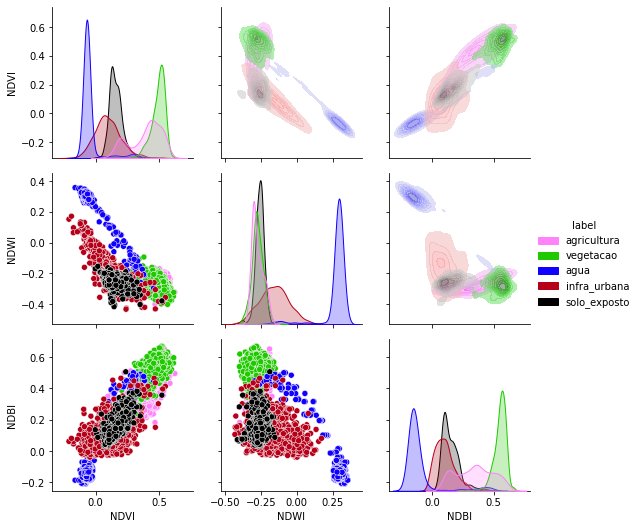

In [ ]:
##Plotando o gráfico para análise!
plt.figure(figsize = (15,15))
g = sns.PairGrid(gdf[['NDVI', 'NDWI', 'NDBI','label']],hue = "label",palette = sns.color_palette(colors))
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot,fill = True,alpha = .5)
g.map_diag(sns.kdeplot,fill = True)
g.add_legend()
plt.show()

# ***POST 3 - GEOPANDAS***

In [ ]:
##A partir de um geodatrame utilizaremos os valores obtidos para cada amostra
gdf = gpd.read_file('/content/drive/MyDrive/GEE_PYTHON/classes_de_uso.shp')
gdf = gdf[['label','B2','B3','B4','B5',	'B6','B7','B8','geometry']]
gdf

,label,B2,B3,B4,B5,B6,B7,B8,geometry
0,agricultura,0.03460,0.06750,0.05950,0.12635,0.22035,0.26870,0.3074,POINT (-51.90767 -29.70724)
1,agricultura,0.02985,0.05325,0.04060,0.07880,0.23435,0.32285,0.2911,POINT (-51.96534 -29.61651)
2,agricultura,0.04145,0.07915,0.06885,0.14975,0.25095,0.29690,0.3048,POINT (-51.91476 -29.72386)
3,agricultura,0.03035,0.06160,0.04015,0.09880,0.24330,0.29620,0.2949,POINT (-51.91099 -29.71236)
4,agricultura,0.07005,0.11170,0.13350,0.20080,0.27425,0.31985,0.3493,POINT (-51.90767 -29.71272)
...,...,...,...,...,...,...,...,...,...
4995,solo_exposto,0.05405,0.07800,0.09175,0.13090,0.18805,0.21485,0.2284,POINT (-51.93111 -29.71227)
4996,solo_exposto,0.06015,0.08715,0.11150,0.15370,0.18580,0.20630,0.2114,POINT (-51.77894 -29.79348)
4997,solo_exposto,0.06695,0.09360,0.12450,0.15345,0.17800,0.20285,0.2169,POINT (-51.77957 -29.78935)
4998,solo_exposto,0.06580,0.09260,0.12280,0.15170,0.18710,0.21065,0.2212,POINT (-51.77948 -29.79150)


In [ ]:
##Calcularemos os seguintes índices
indicesToCompute = ["NDVI","NDWI","NDBI"]

#Agora, vamos inserir as colunas dos índices e utilizar o spyndex para computar os dados
gdf[indicesToCompute] = spyndex.computeIndex(
    index = indicesToCompute,
    params = {
        "G": gdf["B3"],
        "R": gdf["B4"],
        "N": gdf["B5"],
        "S1": gdf["B6"],
    }
)

[Text(0.5, 1.0, 'NDBI')]

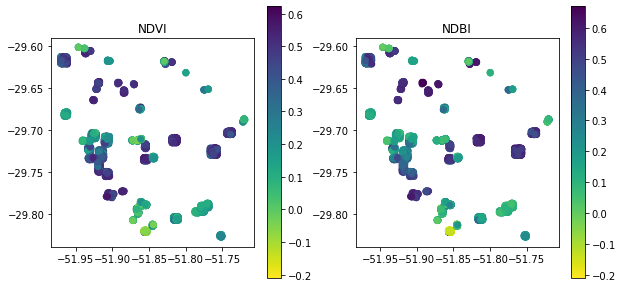

In [ ]:
fig, ax = plt.subplots(1, 2,figsize = (10,5))

gdf.plot(column = 'NDVI',legend = True,ax = ax[0],cmap = "viridis_r")
ax[0].set(title = "NDVI")

gdf.plot(column = 'NDBI',legend = True,ax = ax[1],cmap = "viridis_r")
ax[1].set(title = "NDBI")